# Stable diffusion from Scratch

## How it works

Stable Diffusion operates differently compared to many other image generation models as a diffusion model. In simple terms, diffusion models use fuzzy noise to encode an image. They then use a noise predictor along with a reverse diffusion process to put the image back together.

Beyond the technical differences of a diffusion model, Stable Diffusion stands out by not using the pixel space of the image. Instead, it uses a simplified latent space.

This choice is driven by the fact that a color image with 512x512 resolution has a huge number of potential values. In comparison, Stable Diffusion uses a compressed image that is 48 times smaller, containing fewer values. This significant reduction in processing requirements allows the use of Stable Diffusion on a desktop computer with an NVIDIA GPU featuring 8 GB of RAM. The effectiveness of the smaller latent space is based on the idea that natural images follow patterns rather than randomness. Stable Diffusion uses variational autoencoder (VAE) files in the decoder to capture intricate details such as eyes.

## Architecture of Stable Diffusion

2. Forward Diffusion:
Adds Gaussian noise to an image progressively until only random noise remains.

Used during training but not for other tasks, except image-to-image conversion.

3. Reverse Diffusion:
Iteratively undoes forward diffusion.

Trained on billions of images using prompts to create unique images.

In [2]:
import numpy as np
import functools
import math

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# from torch.optim import Adam
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
# from torchvision.datasets import MNIST

# # Import 'tqdm' for creating progress bars during training.
# import tqdm
# from tqdm.notebook import trange, tqdm

# from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

# import matplotlib.pyplot as plt
# from torchvision.utils import make_grid
# from einops import rearrange

## Creating basic forward diffusion

Let’s begin with forward diffusion. In basic terms, the diffusion equation is:

$$ x(t+\Delta{t}) = x(t) + \sigma(t) \sqrt{\Delta{t}} \cdot r $$

Here, $\sigma(t) > 0$ is the noise strength, $\Delta{t}$ is the step size, and $r \sim \mathbf{N}(0, 1)$ is a standard normal random variable. Simply put, we keep adding normally-distributed noise to our sample. Usually, the noise strength $\sigma(t)$ is chosen to increase with time (as t gets larger).

In [3]:
# Forward diffusion for N steps in 1D.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - t0: Initial time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = t0 + np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for diffusion simulation
    for i in range(nsteps):

        # Get the noise strength at the current time
        noise_strength = noise_strength_fn(t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using Euler-Maruyama method
        x[i + 1] = x[i] + random_normal * noise_strength

    # Return the trajectory and corresponding time points
    return x, t

In [4]:
# Example noise strength function: always equal to 1
def noise_strength_constant(t):
    """
    Example noise strength function that returns a constant value (1).

    Parameters:
    - t: Time parameter (unused in this example)

    Returns:
    - Constant noise strength (1)
    """
    return 1

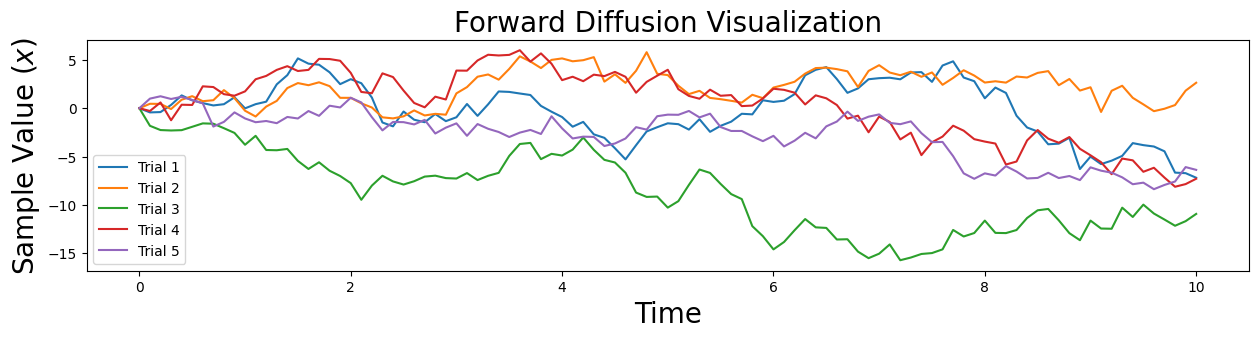

In [6]:
# Number of diffusion steps
nsteps = 100

# Initial time
t0 = 0

# Time step size
dt = 0.1

# Noise strength function
noise_strength_fn = noise_strength_constant

# Initial sample value
x0 = 0

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):

    # Simulate forward diffusion
    x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Forward Diffusion Visualization', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()

This visualization illustrates the forward diffusion process, which can be understood as slowly introducing noise to the starting sample. This leads to the creation of various samples as the diffusion process progresses, as depicted in the graph.

## Creating basic reverse diffusion

To undo this diffusion process, we use a similar update rule:

$$x(t+\Delta{t}) = x(t) + \sigma(T-t)^2 \frac{d}{dx}[\log{p(x, T-t)}]\Delta{t} + \sigma(T-t)\sqrt{\Delta{t}} \cdot r $$

Here, 

$$s(x,t) = \frac{d}{dx}\log{p(x, t)}$$

is known as the score function. Knowing this function allows us to reverse the forward diffusion and convert noise back into our initial state.

If our starting point is always just one point at $x_0=0$, and the noise strength is constant, then the score function is exactly equal to 
$$ s(x, t) = -(x-x_0)\sigma^2t = -x\sigma^2t$$

## Resources

* https://github.com/FareedKhan-dev/create-stable-diffusion-from-scratch/blob/main/Stable_Diffusion_From_Scratch_Notebook.ipynb
* https://encord.com/blog/diffusion-models/
* https://abdulkaderhelwan.medium.com/what-is-a-reverse-diffusion-model-5e6b69af2745
* https://ychai.uk/notes/2022/12/12/Diffusion-Models-Math-Guide/
* https://medium.com/@kemalpiro/step-by-step-visual-introduction-to-diffusion-models-235942d2f15c
* https://github.com/InFoCusp/diffusion_models/blob/main/Diffusion_models.ipynb
* https://github.com/tanelp/tiny-diffusion/blob/master/ddpm.py [**]
